<a href="https://colab.research.google.com/github/dorian-goueytes/L3_mineure_psycho_exp-/blob/main/intro_to_ddm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Dans ce segment du TD nous allons mettre en oeuvre un modèle de prise de décision similaire à celui que nous avons vu dans l'article Dondé et al. (2025). Characterizing early auditory deficits in schizophrenia using drift-diffusion modeling.

Nous utiliserons ce modèle pour explorer les données comportementales issues de primate non-humain en provenance de l'article Roitman, J. D., & Shadlen, M. N. (2002). Response of Neurons in the Lateral Intraparietal Area during a Combined Visual Discrimination Reaction Time Task. The Journal of Neuroscience, 22(21), 9475‑9489. https://doi.org/10.1523/JNEUROSCI.22-21-09475.2002

Dans cet article des singes rhesus devaient effectuer la tâche illustrée ci-dessous, pendant que les chercheurs enregistraient leur données comportementales, mais aussi l'activité neuronale dans le cortex pariétal.

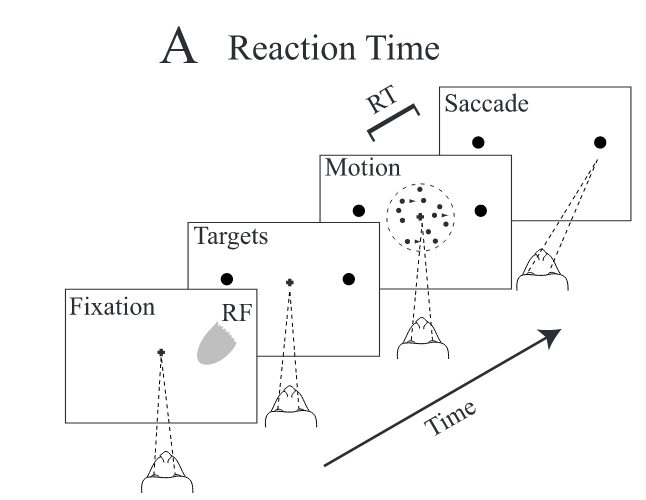


# Libraries and dependencies

In [ ]:
!pip install pyddm
import matplotlib.pyplot as plt
import pyddm
import pyddm.plot
from pyddm import Sample
import numpy as np
import pandas as pd
from pyddm import Model
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter, ICPoint, OverlayNone, BoundCollapsingExponential, OverlayPoissonMixture,OverlayChain
from pyddm.functions import display_model
from pyddm import Fittable, Fitted
from pyddm import LossRobustLikelihood
from pyddm import Sample

## Helper functionsclass DriftCoherence(pyddm.models.Drift):
class DriftCoherence(pyddm.models.Drift):
    name = "Drift depends linearly on coherence"
    required_parameters = ["driftcoh"] # <-- Parameters we want to include in the model
    required_conditions = ["coh"] # <-- Task parameters ("conditions"). Should be the same name as in the sample.

    # We must always define the get_drift function, which is used to compute the instantaneous value of drift.
    def get_drift(self, conditions, **kwargs):
        return self.driftcoh * conditions['coh']

# Chargement des données

In [ ]:
with open("roitman_rts.csv", "r") as f:
    df_rt = pd.read_csv(f)

df_rt = df_rt[df_rt["monkey"] == 1] # Only monkey 1
df_rt = df_rt[df_rt["rt"] > .1] # Remove trials less than 100ms
df_rt = df_rt[df_rt["rt"] < 1.65] # Remove trials greater than 1650ms
roitman_sample = Sample.from_pandas_dataframe(df_rt, rt_column_name="rt", choice_column_name="correct")

## Visualisation des données

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)
ax1.hist(df_rt['rt'].to_numpy()[np.where(df_rt["correct"]==1)[0]], bins = 100, color = 'g', label = 'correct')#, density = True)
ax1.set_ylim(0, 85)
ax1.set_ylabel("Trial Count")
ax2.hist(df_rt['rt'].to_numpy()[np.where(df_rt["correct"]==0)[0]],  bins = 100, color = 'r', label = 'error')#, density = True)
ax2.set_ylim(0, 85)
ax2.set_ylabel("Trial Count")
ax2.invert_yaxis()

ax1.legend()
ax2.legend()
plt.xlabel("Reaction Time")

plt.suptitle('Distribution of reaction times for correct and error trials')
plt.subplots_adjust(hspace=0)
plt.show()
print("Taux de réponses correctes : ", str(len(np.where(df_rt['correct'] ==1)[0])/len(df_rt['correct'])*100)+" %")

# Création d'un modèle simple

Pour continuer sur la lancée de la première partie du cours, nous allons maintenant créer notre premier modèle de diffusion.

Ce modèle comporte trois paramètres que vous pouvez manipuler pour observer leur effet.

In [ ]:
model_to_fit = Model(name='Simple model',
                  drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  #bound=BoundConstant(B=1.1),
                  bound=BoundConstant(B = Fittable(minval=.5, maxval=1.5)),
                  IC = ICPoint(x0 = Fittable(minval=.5, maxval=1)),
                  overlay=OverlayNonDecision(nondectime=0.3),
                  dx=.001, dt=.001, T_dur=2)


pyddm.plot.model_gui_jupyter(model_to_fit) #to use to give a quick analogy with data

## Observation d'essais uniques

Dans ce segment nous allons simuler des essais uniques et observers l'accumulation d'évidence en fonction du temps pour un modèle de diffusion. Ce modèle comporte deux paramètres additionnels par rapport au précédent, le bias et le seuil (bound)

Lorsque vous exécutez la cellule 10 essais sont simulés. Vous pouvez manipuler les différents paramètres du modèle avec les slider et ré-exécuter pour voir l'effet de votre manipulation.

In [ ]:
# @title Simulation de 10 essais individuels
plt.figure()

drift = 1 # @param {type:"slider", min:0, max:4, step:0.5}
noise = 2 # @param {type:"slider", min:0, max:4, step:0.5}
bound = 1 # @param {type:"slider", min:0, max:2, step:0.1}
bias = 0.5 # @param {type:"slider", min:0, max:0.9, step:0.1}

model = Model(name='Simple model',
              drift=DriftConstant(drift=drift),
              noise=NoiseConstant(noise=noise),
              bound=BoundConstant(B=1.1),
              IC = ICPoint(x0=bound - (bound*2*bias)),
              overlay=OverlayNonDecision(nondectime=.1),
              dx=.001, dt=.01, T_dur=2.5)
#model.show()

for i in range(0,10):
  trial = model.simulate_trial(seed=np.random.randint(0,1000))
  plt.plot(np.linspace(0,2.5, len(trial)), trial)
plt.axhline(bound, color='r', linestyle='--', label='Upper bound')
plt.axhline(-bound, color='b', linestyle='--', label='Lower bound')
plt.xlabel("Time (s)")
plt.ylabel("Evidence")
plt.title("Single-trial evidence accumulation")
plt.legend()
plt.show()

# Création et fitting d'un modèle au donnée de Roitman et al.

## Création du modèle

In [ ]:
model_rs = Model(name='Roitman data, drift varies with coherence',
                 drift=DriftCoherence(driftcoh=Fittable(minval=0, maxval=20)),
                 noise=NoiseConstant(noise=1),
                 bound=BoundConstant(B=Fittable(minval=.1, maxval=1.5)),
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)), OverlayPoissonMixture(pmixturecoef=.02, rate=1)]),
                 dx=.001, dt=.001, T_dur=2)

## Visualisation et ajustement manuel

In [ ]:
pyddm.plot.model_gui_jupyter(model_rs, sample=roitman_sample)

## Fitting et visualisation du modèle fitté

In [ ]:
model_rs.fit(sample=roitman_sample, verbose=False)
pyddm.plot.model_gui_jupyter(model_rs, sample=roitman_sample)

In [ ]:
# @title Simulation de 10 essais individuels
plt.figure()

drift = "0"  # @param [0, 0.032, 0.064, 0.128, 0.256, 0.512]

bound = 0.7468939816945264
ndtime = 0.30874108238354847

model = Model(name='Simple model',
              drift=DriftConstant(drift=10.32*float(drift)),
              bound=BoundConstant(B=bound),
              overlay=OverlayNonDecision(nondectime=ndtime),
              dx=.001, dt=.01, T_dur=2)


for i in range(0,20):
  trial = model.simulate_trial(seed=np.random.randint(0,1000), cutoff=False)
  plt.plot(np.linspace(0,2, len(trial)), trial)
  plt.ylim(-bound-0.1,bound+0.1)
plt.axhline(bound, color='b', linestyle='--', label='Correct answer')
plt.axhline(-bound, color='r', linestyle='--', label='Error')
plt.xlabel("Time (s)")
plt.ylabel("Evidence")
plt.title("Single-trial evidence accumulation")
plt.legend()
plt.show()